In [12]:
import importlib
import sys

# not sure if there is an easier way to reload the nn module when I change it
import nn
importlib.reload(sys.modules['nn'])
from nn import Value, SimpleNN
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as py_nn
import torch.optim as optim

from micrograd.nn import MLP
from micrograd.engine import Value as KValue

In [4]:
def rand_vec(size):
    return [Value(random.uniform(-1, 1)) for _ in range(size)] # Now using a Value here

In [5]:
def sum_values(vec):
    s = Value(0)
    for v in vec:
        s += v
    return s

In [6]:
def loss(net: SimpleNN, example: tuple[list[float], float]):
    return (net.forward(example[0]) - example[1]).sq()

In [7]:
def update_fn(learning_rate: float):
    def update(w: Value):
        return Value(w.data - learning_rate * w.grad)
    return update

In [8]:
def generate_sum_fn_training_data(num_examples, input_size):
    training_data = [rand_vec(input_size) for _ in range(num_examples)]
    training_data = [(x, sum_values(x)) for x in training_data]
    return training_data

training_data = generate_sum_fn_training_data(10, 2)
print(training_data[0])
print(sum_values(training_data[0][0]))

([Value(label=, data=0.08426491671592773), Value(label=, data=-0.8395857167394767)], Value(label=, data=-0.755320800023549))
Value(label=, data=-0.755320800023549)


In [9]:
# Pytorch model for comparison

class PTNet(py_nn.Module):
    def __init__(self, layer_sizes: list[int]):
        super(PTNet, self).__init__()
        layers = []
        assert len(layer_sizes) > 0, "One layer needed for input"
        for i in range(len(layer_sizes) - 1):
            layers.append(py_nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(py_nn.ReLU())
        layers.append(py_nn.Linear(layer_sizes[-1], 1))
        self.model = py_nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [33]:
def local_scope():
    nn = MLP(5, [1])
    print(nn([random.random() for _ in range(5)]))
local_scope()

Value(data=0.41063906520924115, grad=0)


In [48]:
def fit_sum_experiment(input_size, learning_rate, training_steps, training_data_size, layer_sizes: list[int]):
    training_data = generate_sum_fn_training_data(training_data_size, input_size)
    my_nn = SimpleNN(input_size, layer_sizes)
    pt_nn = PTNet([input_size] + layer_sizes)

    criterion = py_nn.MSELoss()
    optimizer = optim.SGD(pt_nn.parameters(), lr=learning_rate)

    x_train = torch.rand(training_data_size, input_size)
    y_train = x_train.sum(dim=1, keepdim=True)

    my_training_data = []
    for inputs, result in zip(x_train, y_train):
        my_training_data.append([[Value(v) for v in inputs.tolist()], Value(result.item())])

    k_training_data = []
    for inputs, result in zip(x_train, y_train):
        k_training_data.append([[v for v in inputs.tolist()], KValue(result.item())])

    print(x_train[0])
    print(my_training_data[0][0])
    print(y_train[0])
    print(my_training_data[0][1])

    k_nn = MLP(input_size, layer_sizes + [1])

    print(f"KNN check {k_nn(k_training_data[0][0])}")

    my_losses = []
    k_losses = []
    pt_losses = []
    for step in range(training_steps):
        
        # For the two scarlar based models, loop through the training data
        my_sum_loss = 0.0
        k_sum_loss = 0.0
        for example in my_training_data:
            my_current_loss = loss(my_nn, example)
            my_sum_loss += my_current_loss.data
            my_nn.backward(update_fn(learning_rate), my_current_loss)

        for example in k_training_data:
            k_nn.zero_grad()
            k_current_loss = (example[1] - k_nn(example[0]))**2
            k_sum_loss += k_current_loss.data
            k_current_loss.backward()
            for param in k_nn.parameters():
                param.data = param.data - learning_rate * param.grad
        
        my_losses.append(my_sum_loss / len(x_train))
        print(f"MyNN: Epoch {step+1}, Loss: {my_losses[-1]}")

        k_losses.append(k_sum_loss / len(x_train))
        print(f"KNN: Epoch {step+1}, Loss: {k_losses[-1]}")
        
        optimizer.zero_grad()
        outputs = pt_nn(x_train)
        pt_loss = criterion(outputs, y_train)
        pt_loss.backward()
        optimizer.step()

        print(f'Epoch {step+1}, Loss: {pt_loss.item()}')
        pt_losses.append(pt_loss.item())
        
    plt.plot(my_losses[-5:], label="my_losses")
    plt.plot(k_losses[-5:], label="k_losses")
    plt.plot(pt_losses[-5:], label="py_losses")
    plt.legend()
    plt.show()

tensor([0.8333, 0.3392, 0.2870, 0.1524, 0.6411])
[Value(label=, data=0.8333094716072083), Value(label=, data=0.3392459750175476), Value(label=, data=0.2870160937309265), Value(label=, data=0.1523873209953308), Value(label=, data=0.6410520076751709)]
tensor([2.2530])
Value(label=, data=2.2530109882354736)
KNN check Value(data=0.8506127327111688, grad=0)
MyNN: Epoch 1, Loss: 0.09751449250275868
KNN: Epoch 1, Loss: 0.07157635102330166
Epoch 1, Loss: 9.326949119567871
MyNN: Epoch 2, Loss: 0.0008913402167919898
KNN: Epoch 2, Loss: 0.0041885607007942196
Epoch 2, Loss: 8.643608093261719
MyNN: Epoch 3, Loss: 0.00031515368270600055
KNN: Epoch 3, Loss: 0.0017835688891710793
Epoch 3, Loss: 8.045482635498047
MyNN: Epoch 4, Loss: 0.00018194456874563727
KNN: Epoch 4, Loss: 0.0009895940017846875
Epoch 4, Loss: 7.511300086975098
MyNN: Epoch 5, Loss: 0.00012183210616938379
KNN: Epoch 5, Loss: 0.000648120900818183
Epoch 5, Loss: 7.025822162628174
MyNN: Epoch 6, Loss: 9.010210532815727e-05
KNN: Epoch 6, 

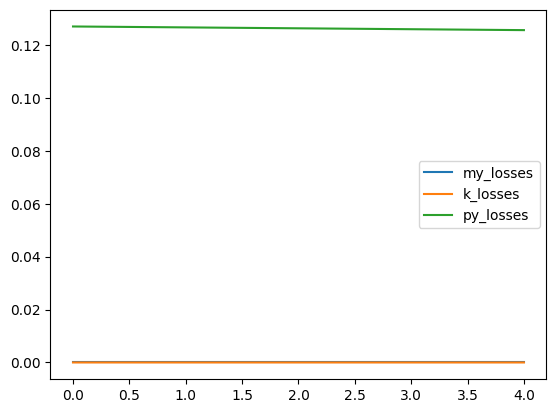

In [49]:
fit_sum_experiment(
    input_size=5,
    learning_rate=0.01,
    training_steps=100,
    training_data_size=1000,
    layer_sizes=[10, ],
)

Hmmm so kinda working?